In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 11.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import os
import random
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,random_split,SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
def seed_everything(seed=3407):
    """
    Seed everything to make all operations in PyTorch (and other libraries) deterministic.
    Args:
        seed (int): Seed value to set.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.dataframe.iloc[idx]['X_cont'], dtype=torch.float32)

        other_cols = self.dataframe.drop(columns=['label', 'X_cont','Unit1'])
        x_other = torch.tensor(other_cols.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.long)

        return x_cont, x_other, label

In [ ]:
class BayesianLSTM(nn.Module):
    def __init__(self, dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2):
        super(BayesianLSTM, self).__init__()
        # lstm part
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(dyn_channels, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 15)

        # fc part
        self.fc_static1 = nn.Linear(stat_channels,30)
        self.fc_static2 = nn.Linear(30,15)

        # fusion part
        self.fc_final1 = nn.Linear(30,2)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x_dynamic, x_static):
        h0 = torch.zeros(self.num_layers, x_dynamic.size(0), self.hidden_size).to(x_dynamic.device)
        c0 = torch.zeros(self.num_layers, x_dynamic.size(0), self.hidden_size).to(x_dynamic.device)
        out1, _ = self.lstm(x_dynamic, (h0, c0))
        out1 = self.relu(self.fc1(out1[:, -1, :]))
        out1 = self.relu(self.fc2(out1))

        out2 = self.relu(self.fc_static1(x_static))
        out2 = self.relu(self.fc_static2(out2))

        out = torch.cat((out1, out2), dim=1)
        out = self.fc_final1(out)

        return out
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = BayesianLSTM(dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2).to(device)
log_softmax = nn.LogSoftmax(dim=1)
def model(x_dynamic, x_static, y=None):
        # Define prior distributions for all neural network weights
        lstm_weightih0_prior = dist.Normal(loc=torch.zeros_like(net.lstm.weight_ih_l0).to(device), scale=1*torch.ones_like(net.lstm.weight_ih_l0).to(device)).to_event(2)
        lstm_biasih0_prior = dist.Normal(loc=torch.zeros_like(net.lstm.bias_ih_l0).to(device), scale=1*torch.ones_like(net.lstm.bias_ih_l0).to(device)).to_event(1)
        lstm_weightih1_prior = dist.Normal(loc=torch.zeros_like(net.lstm.weight_ih_l1).to(device), scale=1*torch.ones_like(net.lstm.weight_ih_l1).to(device)).to_event(2)
        lstm_biasih1_prior = dist.Normal(loc=torch.zeros_like(net.lstm.bias_ih_l1).to(device), scale=1*torch.ones_like(net.lstm.bias_ih_l1).to(device)).to_event(1)
        lstm_weighthh0_prior = dist.Normal(loc=torch.zeros_like(net.lstm.weight_hh_l0).to(device), scale=1*torch.ones_like(net.lstm.weight_hh_l0).to(device)).to_event(2)
        lstm_biashh0_prior = dist.Normal(loc=torch.zeros_like(net.lstm.bias_hh_l0).to(device), scale=1*torch.ones_like(net.lstm.bias_hh_l0).to(device)).to_event(1)
        lstm_weighthh1_prior = dist.Normal(loc=torch.zeros_like(net.lstm.weight_hh_l1).to(device), scale=1*torch.ones_like(net.lstm.weight_hh_l1).to(device)).to_event(2)
        lstm_biashh1_prior = dist.Normal(loc=torch.zeros_like(net.lstm.bias_hh_l1).to(device), scale=1*torch.ones_like(net.lstm.bias_hh_l1).to(device)).to_event(1)
        #lstm_weighthr0_prior = dist.Normal(loc=torch.zeros_like(self.lstm.weight_hr_l0), scale=torch.ones_like(self.lstm.weight_hr_l0))
        #lstm_biashr0_prior = dist.Normal(loc=torch.zeros_like(self.lstm.bias_hr_l0), scale=torch.ones_like(self.lstm.bias_hr_l0))
        #lstm_weighthr1_prior = dist.Normal(loc=torch.zeros_like(self.lstm.weight_hr_l1), scale=torch.ones_like(self.lstm.weight_hr_l1))
        #lstm_biashr1_prior = dist.Normal(loc=torch.zeros_like(self.lstm.bias_hr_l1), scale=torch.ones_like(self.lstm.bias_hr_l1))
        fc1w_prior = dist.Normal(loc=torch.zeros_like(net.fc1.weight).to(device), scale=1*torch.ones_like(net.fc1.weight).to(device)).to_event(2)
        fc1b_prior = dist.Normal(loc=torch.zeros_like(net.fc1.bias).to(device), scale=1*torch.ones_like(net.fc1.bias).to(device)).to_event(1)
        fc2w_prior = dist.Normal(loc=torch.zeros_like(net.fc2.weight).to(device), scale=1*torch.ones_like(net.fc2.weight).to(device)).to_event(2)
        fc2b_prior = dist.Normal(loc=torch.zeros_like(net.fc2.bias).to(device), scale=1*torch.ones_like(net.fc2.bias).to(device)).to_event(1)
        fc_static1w_prior = dist.Normal(loc=torch.zeros_like(net.fc_static1.weight).to(device), scale=1*torch.ones_like(net.fc_static1.weight).to(device)).to_event(2)
        fc_static1b_prior = dist.Normal(loc=torch.zeros_like(net.fc_static1.bias).to(device), scale=1*torch.ones_like(net.fc_static1.bias).to(device)).to_event(1)
        fc_static2w_prior = dist.Normal(loc=torch.zeros_like(net.fc_static2.weight).to(device), scale=1*torch.ones_like(net.fc_static2.weight).to(device)).to_event(2)
        fc_static2b_prior = dist.Normal(loc=torch.zeros_like(net.fc_static2.bias).to(device), scale=1*torch.ones_like(net.fc_static2.bias).to(device)).to_event(1)
        fc_final1w_prior = dist.Normal(loc=torch.zeros_like(net.fc_final1.weight).to(device), scale=1*torch.ones_like(net.fc_final1.weight).to(device)).to_event(2)
        fc_final1b_prior = dist.Normal(loc=torch.zeros_like(net.fc_final1.bias).to(device), scale=1*torch.ones_like(net.fc_final1.bias).to(device)).to_event(1)


        model_priors = {
            'lstm.weight_ih_l0': lstm_weightih0_prior, 'lstm.bias_ih_l0': lstm_biasih0_prior,
            'lstm.weight_ih_l1': lstm_weightih1_prior, 'lstm.bias_ih_l1': lstm_biasih1_prior,
            'lstm.weight_hh_l0': lstm_weighthh0_prior, 'lstm.bias_hh_l0': lstm_biashh0_prior,
            'lstm.weight_hh_l1': lstm_weighthh1_prior, 'lstm.bias_hh_l1': lstm_biashh1_prior,
            #'lstm.weight_hr_l0': lstm_weighthr0_prior, 'lstm.bias_hr_l0': lstm_biashr0_prior,
            #'lstm.weight_hr_l1': lstm_weighthr1_prior, 'lstm.bias_hr_l1': lstm_biashr1_prior,
            'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
            'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior,
            'fc_static1.weight': fc_static1w_prior, 'fc_static1.bias': fc_static1b_prior,
            'fc_static2.weight': fc_static2w_prior, 'fc_static2.bias': fc_static2b_prior,
            #'fc_static3.weight': fc_static3w_prior, 'fc_static3.bias': fc_static3b_prior,
            'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior,
            #'fc_final2.weight': fc_final2w_prior, 'fc_final2.bias': fc_final2b_prior
        }
        lifted_module = pyro.random_module("module", net, model_priors)  # Lift module parameters to random variables
        lifted_reg_model = lifted_module()
        #with pyro.plate("data", x_dynamic.size(0)):
        lhat = log_softmax(lifted_reg_model(x_dynamic, x_static))
        if y is not None:
                y = y.float()
        pyro.sample("obs", dist.Categorical(logits=lhat).to_event(1), obs=y)
        return lhat


# Defining the guide function for variational inference
softplus = torch.nn.Softplus()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def guide(x_dynamic, x_static, y=None):
        # Define variational distributions for the parameters (learnable)
        #softplus = torch.nn.Softplus()
        lstm_weightih0_mu = torch.randn_like(net.lstm.weight_ih_l0)
        lstm_weightih0_sigma = torch.randn_like(net.lstm.weight_ih_l0)
        lstm_weightih0_mu_param = pyro.param("lstm_weightih0_mu", lstm_weightih0_mu).to(device)
        lstm_weightih0_sigma_param = softplus(pyro.param("lstm_weightih0_sigma", lstm_weightih0_sigma).to(device))
        lstm_weightih0_prior = dist.Normal(loc=lstm_weightih0_mu_param, scale=lstm_weightih0_sigma_param).to_event(2)
        lstm_biasih0_mu = torch.randn_like(net.lstm.bias_ih_l0)
        lstm_biasih0_sigma = torch.randn_like(net.lstm.bias_ih_l0)
        lstm_biasih0_mu_param = pyro.param("lstm_biasih0_mu", lstm_biasih0_mu).to(device)
        lstm_biasih0_sigma_param = softplus(pyro.param("lstm_biasih0_sigma", lstm_biasih0_sigma).to(device))
        lstm_biasih0_prior = dist.Normal(loc=lstm_biasih0_mu_param, scale=lstm_biasih0_sigma_param).to_event(1)

        lstm_weightih1_mu = torch.randn_like(net.lstm.weight_ih_l1)
        lstm_weightih1_sigma = torch.randn_like(net.lstm.weight_ih_l1)
        lstm_weightih1_mu_param = pyro.param("lstm_weightih1_mu", lstm_weightih1_mu).to(device)
        lstm_weightih1_sigma_param = softplus(pyro.param("lstm_weightih1_sigma", lstm_weightih1_sigma).to(device))
        lstm_weightih1_prior = dist.Normal(loc=lstm_weightih1_mu_param, scale=lstm_weightih1_sigma_param).to_event(2)
        lstm_biasih1_mu = torch.randn_like(net.lstm.bias_ih_l1)
        lstm_biasih1_sigma = torch.randn_like(net.lstm.bias_ih_l1)
        lstm_biasih1_mu_param = pyro.param("lstm_biasih1_mu", lstm_biasih1_mu).to(device)
        lstm_biasih1_sigma_param = softplus(pyro.param("lstm_biasih1_sigma", lstm_biasih1_sigma).to(device))
        lstm_biasih1_prior = dist.Normal(loc=lstm_biasih1_mu_param, scale=lstm_biasih1_sigma_param).to_event(1)

        lstm_weighthh0_mu = torch.randn_like(net.lstm.weight_hh_l0)
        lstm_weighthh0_sigma = torch.randn_like(net.lstm.weight_hh_l0)
        lstm_weighthh0_mu_param = pyro.param("lstm_weighthh0_mu", lstm_weighthh0_mu).to(device)
        lstm_weighthh0_sigma_param = softplus(pyro.param("lstm_weighthh0_sigma", lstm_weighthh0_sigma).to(device))
        lstm_weighthh0_prior = dist.Normal(loc=lstm_weighthh0_mu_param, scale=lstm_weighthh0_sigma_param).to_event(2)
        lstm_biashh0_mu = torch.randn_like(net.lstm.bias_hh_l0)
        lstm_biashh0_sigma = torch.randn_like(net.lstm.bias_hh_l0)
        lstm_biashh0_mu_param = pyro.param("lstm_biashh0_mu", lstm_biashh0_mu).to(device)
        lstm_biashh0_sigma_param = softplus(pyro.param("lstm_biashh0_sigma", lstm_biashh0_sigma).to(device))
        lstm_biashh0_prior = dist.Normal(loc=lstm_biashh0_mu_param, scale=lstm_biashh0_sigma_param).to_event(1)

        lstm_weighthh1_mu = torch.randn_like(net.lstm.weight_hh_l1)
        lstm_weighthh1_sigma = torch.randn_like(net.lstm.weight_hh_l1)
        lstm_weighthh1_mu_param = pyro.param("lstm_weighthh1_mu", lstm_weighthh1_mu).to(device)
        lstm_weighthh1_sigma_param = softplus(pyro.param("lstm_weighthh1_sigma", lstm_weighthh1_sigma).to(device))
        lstm_weighthh1_prior = dist.Normal(loc=lstm_weighthh1_mu_param, scale=lstm_weighthh1_sigma_param).to_event(2)
        lstm_biashh1_mu = torch.randn_like(net.lstm.bias_hh_l1)
        lstm_biashh1_sigma = torch.randn_like(net.lstm.bias_hh_l1)
        lstm_biashh1_mu_param = pyro.param("lstm_biashh1_mu", lstm_biashh1_mu).to(device)
        lstm_biashh1_sigma_param = softplus(pyro.param("lstm_biashh1_sigma", lstm_biashh1_sigma).to(device))
        lstm_biashh1_prior = dist.Normal(loc=lstm_biashh1_mu_param, scale=lstm_biashh1_sigma_param).to_event(1)

        fc1w_mu = torch.randn_like(net.fc1.weight)
        fc1w_sigma = torch.randn_like(net.fc1.weight)
        fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu).to(device)
        fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma).to(device))
        fc1w_prior = dist.Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param).to_event(2)
        fc1b_mu = torch.randn_like(net.fc1.bias)
        fc1b_sigma = torch.randn_like(net.fc1.bias)
        fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu).to(device)
        fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma).to(device))
        fc1b_prior = dist.Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param).to_event(1)

        fc2w_mu = torch.randn_like(net.fc2.weight)
        fc2w_sigma = torch.randn_like(net.fc2.weight)
        fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu).to(device)
        fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma).to(device))
        fc2w_prior = dist.Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param).to_event(2)
        fc2b_mu = torch.randn_like(net.fc2.bias)
        fc2b_sigma = torch.randn_like(net.fc2.bias)
        fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu).to(device)
        fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma).to(device))
        fc2b_prior = dist.Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param).to_event(1)

        fc_static1w_mu = torch.randn_like(net.fc_static1.weight)
        fc_static1w_sigma = torch.randn_like(net.fc_static1.weight)
        fc_static1w_mu_param = pyro.param("fc_static1w_mu", fc_static1w_mu).to(device)
        fc_static1w_sigma_param = softplus(pyro.param("fc_static1w_sigma", fc_static1w_sigma).to(device))
        fc_static1w_prior = dist.Normal(loc=fc_static1w_mu_param, scale=fc_static1w_sigma_param).to_event(2)
        fc_static1b_mu = torch.randn_like(net.fc_static1.bias)
        fc_static1b_sigma = torch.randn_like(net.fc_static1.bias)
        fc_static1b_mu_param = pyro.param("fc_static1b_mu", fc_static1b_mu).to(device)
        fc_static1b_sigma_param = softplus(pyro.param("fc_static1b_sigma", fc_static1b_sigma).to(device))
        fc_static1b_prior = dist.Normal(loc=fc_static1b_mu_param, scale=fc_static1b_sigma_param).to_event(1)

        fc_static2w_mu = torch.randn_like(net.fc_static2.weight)
        fc_static2w_sigma = torch.randn_like(net.fc_static2.weight)
        fc_static2w_mu_param = pyro.param("fc_static2w_mu", fc_static2w_mu).to(device)
        fc_static2w_sigma_param = softplus(pyro.param("fc_static2w_sigma", fc_static2w_sigma).to(device))
        fc_static2w_prior = dist.Normal(loc=fc_static2w_mu_param, scale=fc_static2w_sigma_param).to_event(2)
        fc_static2b_mu = torch.randn_like(net.fc_static2.bias)
        fc_static2b_sigma = torch.randn_like(net.fc_static2.bias)
        fc_static2b_mu_param = pyro.param("fc_static2b_mu", fc_static2b_mu).to(device)
        fc_static2b_sigma_param = softplus(pyro.param("fc_static2b_sigma", fc_static2b_sigma).to(device))
        fc_static2b_prior = dist.Normal(loc=fc_static2b_mu_param, scale=fc_static2b_sigma_param).to_event(1)


        fc_final1w_mu = torch.randn_like(net.fc_final1.weight)
        fc_final1w_sigma = torch.randn_like(net.fc_final1.weight)
        fc_final1w_mu_param = pyro.param("fc_final1w_mu", fc_final1w_mu).to(device)
        fc_final1w_sigma_param = softplus(pyro.param("fc_final1w_sigma", fc_final1w_sigma).to(device))
        fc_final1w_prior = dist.Normal(loc=fc_final1w_mu_param, scale=fc_final1w_sigma_param).to_event(2)
        fc_final1b_mu = torch.randn_like(net.fc_final1.bias)
        fc_final1b_sigma = torch.randn_like(net.fc_final1.bias)
        fc_final1b_mu_param = pyro.param("fc_final1b_mu", fc_final1b_mu).to(device)
        fc_final1b_sigma_param = softplus(pyro.param("fc_final1b_sigma", fc_final1b_sigma).to(device))
        fc_final1b_prior = dist.Normal(loc=fc_final1b_mu_param, scale=fc_final1b_sigma_param).to_event(1)

        guide_priors = {'lstm.weight_ih_l0': lstm_weightih0_prior, 'lstm.bias_ih_l0': lstm_biasih0_prior,'lstm.weight_ih_l1': lstm_weightih1_prior, 'lstm.bias_ih_l1': lstm_biasih1_prior,
                    'lstm.weight_hh_l0': lstm_weighthh0_prior, 'lstm.bias_hh_l0': lstm_biashh0_prior,'lstm.weight_hh_l1': lstm_weighthh1_prior, 'lstm.bias_hh_l1': lstm_biashh1_prior,
                    #'lstm.weight_hr_l0': lstm_weighthr0_prior, 'lstm.bias_hr_l0': lstm_biashr0_prior,'lstm.weight_hr_l1': lstm_weighthr1_prior, 'lstm.bias_hr_l1': lstm_biashr1_prior,
                    'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior, 'fc_static1.weight': fc_static1w_prior, 'fc_static1.bias': fc_static1b_prior,'fc_static2.weight': fc_static2w_prior, 'fc_static2.bias': fc_static2b_prior,
                    'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior}
        lifted_module = pyro.random_module("module", net, guide_priors)
        return lifted_module().to(device)

In [ ]:
trainval_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/train.pkl').reset_index(drop=True)

class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)

N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [ ]:
print(train_df.shape)
print(val.shape)

(28245, 35)
(7061, 35)


In [ ]:
train_dataset = SequenceDataset(train_df)
valid_dataset = SequenceDataset(val)
train_num = len(train_dataset)
val_num = len(valid_dataset)
batch_size=20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw, drop_last=True)

print("using {} samples for training, {} samples for validation.".format(train_num,
                                                                           val_num))

Using 8 dataloader workers every process
using 28245 samples for training, 7061 samples for validation.


In [ ]:
sample = train_dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
for x_dynamic, x_static, y in train_loader:
    print(x_dynamic.shape)
    print(x_static.shape)
    print(y.shape)
    break

torch.Size([10, 5])
torch.Size([32])
tensor(1)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([20, 10, 5])
torch.Size([20, 32])
torch.Size([20])


In [ ]:
num_samples = 20

def predict(x_dynamic, x_static):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x_dynamic, x_static).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #print(mean.numpy())
    return np.argmax(mean.cpu().numpy(), axis=1)#(mean > 0.5).float().reshape(-1)'''

'''
from pyro.infer import Predictive
def predict(x_dynamic, x_static, model, guide, num_samples=100):
    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=["obs", "_RETURN"])
    svi_samples = predictive(x_dynamic, x_static)
    #print(svi_samples)
    if '_RETURN' in svi_samples:
        predictions = torch.stack([svi_samples['_RETURN'][i] for i in range(num_samples)])
    else:
        predictions = torch.stack([svi_samples['obs'][i].float() for i in range(num_samples)])
    predicted_probabilities = torch.mean(predictions, dim=0)
    predicted_labels = predicted_probabilities.argmax(dim=-1)
    return predicted_labels'''

'\nfrom pyro.infer import Predictive\ndef predict(x_dynamic, x_static, model, guide, num_samples=100):\n    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=["obs", "_RETURN"])\n    svi_samples = predictive(x_dynamic, x_static)\n    #print(svi_samples)\n    if \'_RETURN\' in svi_samples:\n        predictions = torch.stack([svi_samples[\'_RETURN\'][i] for i in range(num_samples)])\n    else:\n        predictions = torch.stack([svi_samples[\'obs\'][i].float() for i in range(num_samples)])\n    predicted_probabilities = torch.mean(predictions, dim=0)\n    predicted_labels = predicted_probabilities.argmax(dim=-1)\n    return predicted_labels'

In [ ]:
def train(model, guide, train_loader, valid_loader, num_epochs=30):

    optim = Adam({"lr":1e-3})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    #model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total_train = 0
        for x_dynamic, x_static, y in train_loader:

            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #print(x_dynamic.shape)
            loss = svi.step(x_dynamic, x_static, y)
            total_loss += loss

            with torch.no_grad():
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                #print(f"the prediction prob is:{pred.reshape(-1)}")
                #pred = torch.sigmoid(pred)
            #pred_label = (pred > 0.5).float()
            #print(type(pred_label))
            correct += (pred_label.reshape(-1) == y.cpu().numpy().reshape(-1)).astype(int).sum().item()
            total_train += y.shape[0]
            #print(pred_label.reshape(-1))
            #print(y.shape[0])
        epoch_loss = total_loss / total_train
        epoch_accuracy = correct / total_train
        train_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")
        train_loss_list.append(epoch_loss)

        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y_val in valid_loader:
            #model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y_val = y_val.cuda()
            with torch.no_grad():
                loss = svi.evaluate_loss(x_dynamic, x_static, y_val)
                total_loss += loss
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                #print(pred)
                #pred = torch.sigmoid(pred)
                #pred_label = (pred > 0.5).float()
                total += y_val.shape[0]
                correct += (pred_label.reshape(-1) == y_val.cpu().numpy().reshape(-1)).astype(int).sum().item()

            epoch_loss = total_loss / total
        epoch_accuracy = correct / total
        valid_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}")
        valid_loss_list.append(epoch_loss)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
#net = BayesianLSTM(dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(model, guide, train_loader, valid_loader, num_epochs=30)

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:836: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:


Epoch 1, Train Loss: 1231.6735673058367, Train Accuracy: 0.504284702549575
Epoch 1, Validation Loss: 1082.9625210251415, Validation Accuracy: 0.5172804532577904
Epoch 2, Train Loss: 963.2892128387208, Train Accuracy: 0.5057365439093484
Epoch 2, Validation Loss: 851.764293776558, Validation Accuracy: 0.4964589235127479
Epoch 3, Train Loss: 754.806138920212, Train Accuracy: 0.5027974504249292
Epoch 3, Validation Loss: 666.4535106453612, Validation Accuracy: 0.5018413597733711
Epoch 4, Train Loss: 588.806556106458, Train Accuracy: 0.5112960339943343
Epoch 4, Validation Loss: 516.3238214854816, Validation Accuracy: 0.5092067988668555
Epoch 5, Train Loss: 455.00790302241404, Train Accuracy: 0.5086048158640226
Epoch 5, Validation Loss: 398.01487860747164, Validation Accuracy: 0.5069405099150142
Epoch 6, Train Loss: 349.4271462241309, Train Accuracy: 0.5068342776203966
Epoch 6, Validation Loss: 304.7307133055949, Validation Accuracy: 0.5076487252124646
Epoch 7, Train Loss: 269.7281457720984, 

Text(0.5, 1.0, 'Accuracy curve')

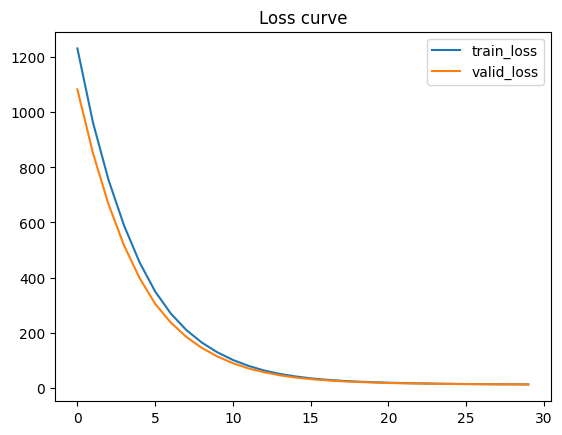

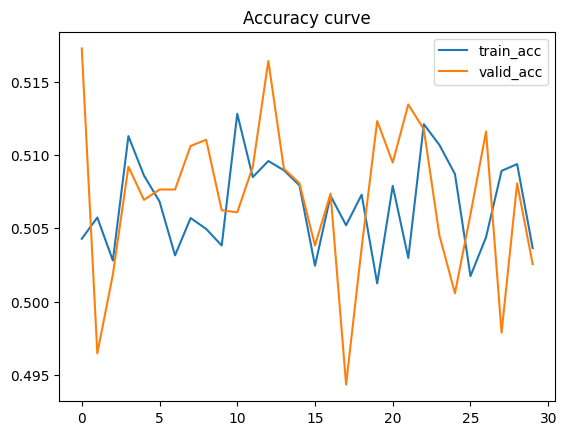

In [ ]:
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend()
plt.title(f"Loss curve")

plt.figure()
plt.plot(train_acc_list, label="train_acc")
plt.plot(valid_acc_list, label="valid_acc")
plt.legend()
plt.title(f"Accuracy curve")

In [ ]:
batch_size=20
test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/test.pkl').reset_index(drop=True)

class_0 = test_df[test_df['label'] == 0]
class_1 = test_df[test_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
test_df = df_balanced.reset_index(drop=True)

N = len(test_df)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.fillna(value=np.pi, inplace=True)
test_dataset = SequenceDataset(test_df)
test_num = len(test_dataset)


test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = False)

In [ ]:
correct = 0
total = 0
y_true=[]
y_pred=[]
for x_dynamic, x_static, y in test_loader:

            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            y = y.float()

            lifted_module = guide(x_dynamic, x_static, y)
            pred_label = predict(x_dynamic, x_static)
            total += y.shape[0]
            correct += (pred_label.reshape(-1) == y.numpy().reshape(-1)).astype(int).sum().item()
            y_true.append(y.reshape(-1))
            y_pred.append(pred_label.reshape(-1))

print(f"the test accuracy is {correct/total}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:836: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (

the test accuracy is 0.5113129381771829


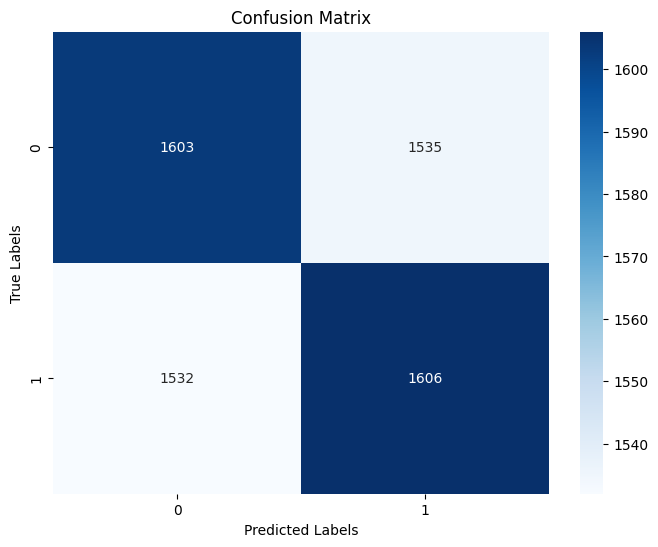

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
CM = confusion_matrix(y_true, y_pred)
#auc_score = roc_auc_score(y_true, y_prob_list, multi_class='ovr')
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt="d", cmap='Blues')#, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(pyro.get_param_store().get_state(), "/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/lstm_bayesian.pth")


In [ ]:
for name, value in pyro.get_param_store().items():
    print(f"Parameter Name: {name}")
    print(f"Values:\n{value}\n")

Parameter Name: lstm_weightih0_mu
Values:
tensor([[ 2.1115e-01, -1.2454e-02, -1.8374e-01,  2.1405e-02, -1.8015e-01],
        [ 7.4891e-02,  2.2729e-03, -8.7458e-02,  6.0947e-03, -5.5029e-02],
        [ 2.2942e-01, -3.1299e-02,  2.7853e-02,  5.0470e-02, -2.9952e-02],
        [ 7.6470e-02,  4.8413e-02, -5.3516e-02,  4.3753e-02,  2.4718e-02],
        [ 2.0439e-01, -7.5248e-02,  7.7588e-02, -1.2148e-01, -9.7662e-02],
        [-4.4130e-02,  1.4514e-01,  1.1541e-02,  1.2403e-01,  1.2041e-01],
        [-7.6482e-02,  3.6444e-02,  1.2039e-01, -2.2632e-01, -8.9553e-02],
        [ 9.4354e-02,  1.3590e-01,  6.3376e-02,  5.8678e-02, -1.2435e-01],
        [-6.0307e-02, -6.5402e-02, -1.9354e-01, -2.3824e-02,  1.6691e-01],
        [ 2.3494e-02,  3.7180e-02, -3.7936e-02, -1.1354e-01,  1.9298e-01],
        [ 1.8613e-01, -5.6117e-02, -1.7197e-01,  8.8035e-02,  6.7120e-02],
        [ 5.0986e-02, -1.2521e-01,  5.6966e-02,  2.4276e-02,  1.7282e-01],
        [ 6.0255e-02, -7.8547e-03, -6.2682e-02,  3.5665e-0